In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                          | 0/60000 [00:00<?, ?it/s]

 13%|██████████████████▍                                                                                                                         | 7918/60000 [00:00<00:00, 79173.66it/s]

 26%|████████████████████████████████████▋                                                                                                      | 15836/60000 [00:00<00:00, 75138.20it/s]

 39%|██████████████████████████████████████████████████████▏                                                                                    | 23364/60000 [00:00<00:00, 73029.04it/s]

 52%|████████████████████████████████████████████████████████████████████████                                                                   | 31083/60000 [00:00<00:00, 74610.36it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                | 39036/60000 [00:00<00:00, 76340.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 46781/60000 [00:00<00:00, 76710.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 54460/60000 [00:00<00:00, 75788.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 75318.30it/s]

  0%|                                                                                                                                                          | 0/10000 [00:00<?, ?it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7004/10000 [00:00<00:00, 70032.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 71938.04it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 kh2l9qec


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/375 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/375 [00:01<06:48,  1.09s/it]

  1%|█▉                                                                                                                                                  | 5/375 [00:01<01:09,  5.29it/s]

  2%|███▌                                                                                                                                                | 9/375 [00:01<00:36,  9.95it/s]

  3%|█████                                                                                                                                              | 13/375 [00:01<00:24, 14.61it/s]

  5%|██████▋                                                                                                                                            | 17/375 [00:01<00:18, 18.99it/s]

  6%|████████▏                                                                                                                                          | 21/375 [00:01<00:15, 22.86it/s]

  7%|█████████▊                                                                                                                                         | 25/375 [00:01<00:13, 26.11it/s]

  8%|███████████▎                                                                                                                                       | 29/375 [00:01<00:12, 28.72it/s]

  9%|████████████▉                                                                                                                                      | 33/375 [00:01<00:11, 30.75it/s]

 10%|██████████████▌                                                                                                                                    | 37/375 [00:02<00:10, 32.29it/s]

 11%|████████████████                                                                                                                                   | 41/375 [00:02<00:10, 33.30it/s]

 12%|█████████████████▋                                                                                                                                 | 45/375 [00:02<00:09, 34.13it/s]

 13%|███████████████████▏                                                                                                                               | 49/375 [00:02<00:09, 34.75it/s]

 14%|████████████████████▊                                                                                                                              | 53/375 [00:02<00:09, 35.21it/s]

 15%|██████████████████████▎                                                                                                                            | 57/375 [00:02<00:08, 35.52it/s]

 16%|███████████████████████▉                                                                                                                           | 61/375 [00:02<00:08, 35.76it/s]

 17%|█████████████████████████▍                                                                                                                         | 65/375 [00:02<00:08, 35.90it/s]

 18%|███████████████████████████                                                                                                                        | 69/375 [00:02<00:08, 36.04it/s]

 19%|████████████████████████████▌                                                                                                                      | 73/375 [00:03<00:08, 36.10it/s]

 21%|██████████████████████████████▏                                                                                                                    | 77/375 [00:03<00:08, 36.17it/s]

 22%|███████████████████████████████▊                                                                                                                   | 81/375 [00:03<00:08, 36.22it/s]

 23%|█████████████████████████████████▎                                                                                                                 | 85/375 [00:03<00:08, 36.22it/s]

 24%|██████████████████████████████████▉                                                                                                                | 89/375 [00:03<00:07, 36.25it/s]

 25%|████████████████████████████████████▍                                                                                                              | 93/375 [00:03<00:07, 36.25it/s]

 26%|██████████████████████████████████████                                                                                                             | 97/375 [00:03<00:07, 36.23it/s]

 27%|███████████████████████████████████████▎                                                                                                          | 101/375 [00:03<00:07, 36.26it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 105/375 [00:03<00:07, 36.28it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 109/375 [00:04<00:07, 36.26it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 113/375 [00:04<00:07, 36.28it/s]

 31%|█████████████████████████████████████████████▌                                                                                                    | 117/375 [00:04<00:07, 36.29it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 121/375 [00:04<00:07, 36.27it/s]

 33%|████████████████████████████████████████████████▋                                                                                                 | 125/375 [00:04<00:06, 36.28it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 129/375 [00:04<00:06, 36.30it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 133/375 [00:04<00:06, 36.31it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 137/375 [00:04<00:06, 36.28it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                           | 141/375 [00:04<00:06, 36.29it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 145/375 [00:05<00:06, 36.29it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 149/375 [00:05<00:06, 36.30it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                      | 153/375 [00:05<00:06, 36.30it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 157/375 [00:05<00:06, 36.29it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 161/375 [00:05<00:05, 36.29it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 165/375 [00:05<00:05, 36.29it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 169/375 [00:05<00:05, 36.29it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                              | 173/375 [00:05<00:05, 36.29it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 177/375 [00:05<00:05, 36.28it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 181/375 [00:06<00:05, 36.29it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 185/375 [00:06<00:05, 36.27it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 189/375 [00:06<00:05, 36.27it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 193/375 [00:06<00:05, 36.27it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 197/375 [00:06<00:04, 36.24it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 201/375 [00:06<00:04, 36.26it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 205/375 [00:06<00:04, 36.27it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                                | 209/375 [00:06<00:04, 36.27it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 213/375 [00:06<00:04, 36.27it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 217/375 [00:07<00:04, 36.27it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 221/375 [00:07<00:04, 36.23it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 225/375 [00:07<00:04, 36.26it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 229/375 [00:07<00:04, 36.27it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 233/375 [00:07<00:03, 36.28it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 237/375 [00:07<00:03, 36.27it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 241/375 [00:07<00:03, 36.27it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 245/375 [00:07<00:03, 36.27it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 249/375 [00:07<00:03, 36.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 253/375 [00:08<00:03, 36.26it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 257/375 [00:08<00:03, 36.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 261/375 [00:08<00:03, 36.27it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 265/375 [00:08<00:03, 36.27it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 269/375 [00:08<00:02, 36.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 273/375 [00:08<00:02, 36.26it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 277/375 [00:08<00:02, 36.26it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 281/375 [00:08<00:02, 36.22it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 285/375 [00:08<00:02, 36.26it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 289/375 [00:09<00:02, 36.27it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 293/375 [00:09<00:02, 36.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 297/375 [00:09<00:02, 36.27it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 301/375 [00:09<00:02, 36.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 305/375 [00:09<00:01, 36.27it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 309/375 [00:09<00:01, 36.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 313/375 [00:09<00:01, 36.27it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 317/375 [00:09<00:01, 36.22it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 321/375 [00:09<00:01, 36.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 325/375 [00:10<00:01, 36.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 329/375 [00:10<00:01, 36.27it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 333/375 [00:10<00:01, 36.27it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 337/375 [00:10<00:01, 36.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 341/375 [00:10<00:00, 36.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 345/375 [00:10<00:00, 36.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 349/375 [00:10<00:00, 36.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 353/375 [00:10<00:00, 36.27it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 357/375 [00:10<00:00, 36.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 361/375 [00:11<00:00, 36.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 365/375 [00:11<00:00, 36.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 369/375 [00:11<00:00, 36.17it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 373/375 [00:11<00:00, 36.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:11<00:00, 32.79it/s]

train - OK


  0%|                                                                                                                                                             | 0/94 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                   | 1/94 [00:00<00:10,  8.96it/s]

  5%|███████▉                                                                                                                                             | 5/94 [00:00<00:03, 24.80it/s]

 10%|██████████████▎                                                                                                                                      | 9/94 [00:00<00:02, 30.01it/s]

 14%|████████████████████▍                                                                                                                               | 13/94 [00:00<00:02, 32.49it/s]

 18%|██████████████████████████▊                                                                                                                         | 17/94 [00:00<00:02, 33.87it/s]

 22%|█████████████████████████████████                                                                                                                   | 21/94 [00:00<00:02, 34.71it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 25/94 [00:00<00:01, 35.24it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 29/94 [00:00<00:01, 35.59it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                | 33/94 [00:00<00:01, 35.83it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                         | 37/94 [00:01<00:01, 35.98it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                   | 41/94 [00:01<00:01, 36.09it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 45/94 [00:01<00:01, 36.16it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 49/94 [00:01<00:01, 36.21it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                | 53/94 [00:01<00:01, 36.26it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 57/94 [00:01<00:01, 36.28it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 61/94 [00:01<00:00, 36.32it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 65/94 [00:01<00:00, 36.32it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/94 [00:01<00:00, 36.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 73/94 [00:02<00:00, 36.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 77/94 [00:02<00:00, 36.35it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 81/94 [00:02<00:00, 36.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 85/94 [00:02<00:00, 36.33it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 89/94 [00:02<00:00, 36.35it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 93/94 [00:02<00:00, 36.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 34.36it/s]

val - OK


  0%|                                                                                                                                                             | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                   | 1/79 [00:00<00:09,  8.30it/s]

  6%|█████████▍                                                                                                                                           | 5/79 [00:00<00:03, 24.03it/s]

 11%|████████████████▉                                                                                                                                    | 9/79 [00:00<00:02, 29.48it/s]

 16%|████████████████████████▎                                                                                                                           | 13/79 [00:00<00:02, 32.12it/s]

 22%|███████████████████████████████▊                                                                                                                    | 17/79 [00:00<00:01, 33.61it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 21/79 [00:00<00:01, 34.49it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 25/79 [00:00<00:01, 35.07it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 29/79 [00:00<00:01, 35.44it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                      | 33/79 [00:01<00:01, 35.70it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 37/79 [00:01<00:01, 35.89it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                       | 41/79 [00:01<00:01, 36.00it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                               | 45/79 [00:01<00:00, 36.08it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 49/79 [00:01<00:00, 36.13it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 53/79 [00:01<00:00, 36.19it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 57/79 [00:01<00:00, 36.21it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 61/79 [00:01<00:00, 36.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 65/79 [00:01<00:00, 36.24it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 69/79 [00:01<00:00, 36.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 73/79 [00:02<00:00, 36.26it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77/79 [00:02<00:00, 36.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.47it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:02, 37.28it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:00<00:02, 37.35it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:00<00:02, 37.30it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:00<00:02, 36.77it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:02, 36.61it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:00<00:02, 36.51it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:00<00:01, 36.47it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:00<00:01, 36.44it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:00<00:01, 36.43it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:01<00:01, 36.41it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:01<00:01, 36.39it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:01<00:01, 36.40it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:01<00:01, 36.39it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:01<00:01, 36.38it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:01, 36.38it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:01<00:00, 36.37it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:01<00:00, 36.29it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:01<00:00, 36.32it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:02<00:00, 36.34it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:02<00:00, 36.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:02<00:00, 36.31it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:02<00:00, 36.35it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:02<00:00, 36.36it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:02<00:00, 36.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.45it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(48000, 1, 32, 32) (48000, 1, 32, 32) (48000, 256) (48000, 10) (48000,)
(12000, 1, 32, 32) (12000, 1, 32, 32) (12000, 256) (12000, 10) (12000,)
(10000, 1, 32, 32) (10000, 1, 32, 32) (10000, 256) (10000, 10) (10000,)
(12800, 1, 32, 32) (12800, 1, 32, 32) (12800, 256) (12800, 10)


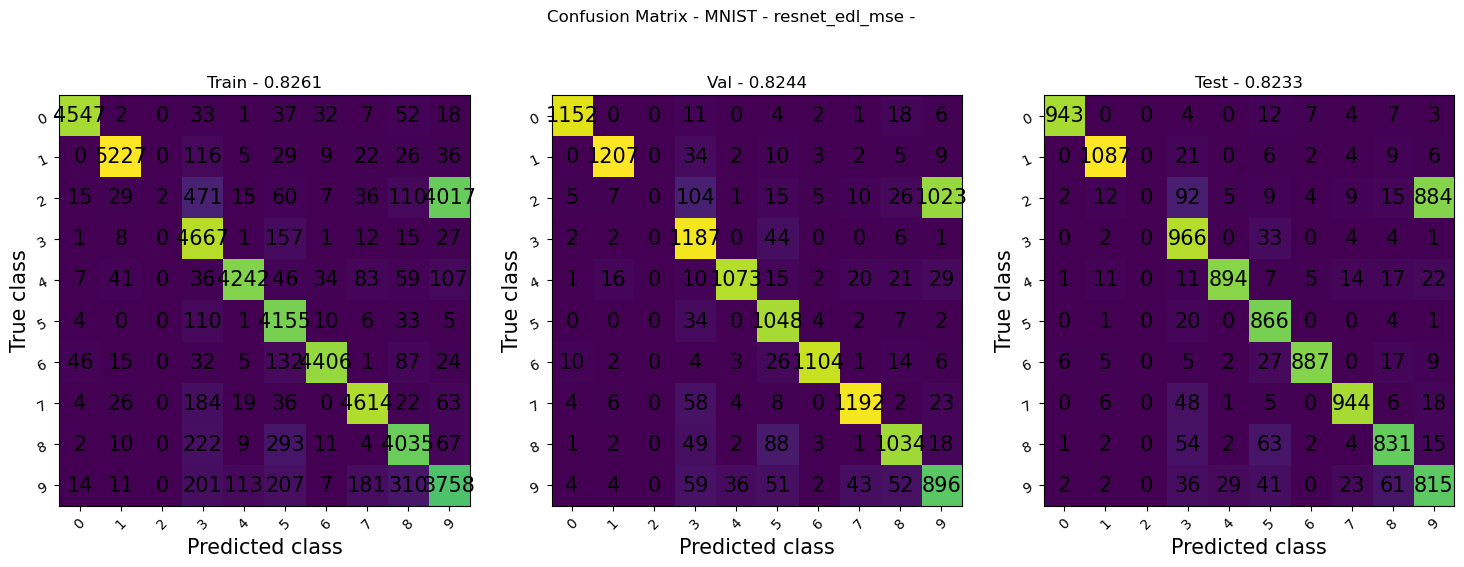

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


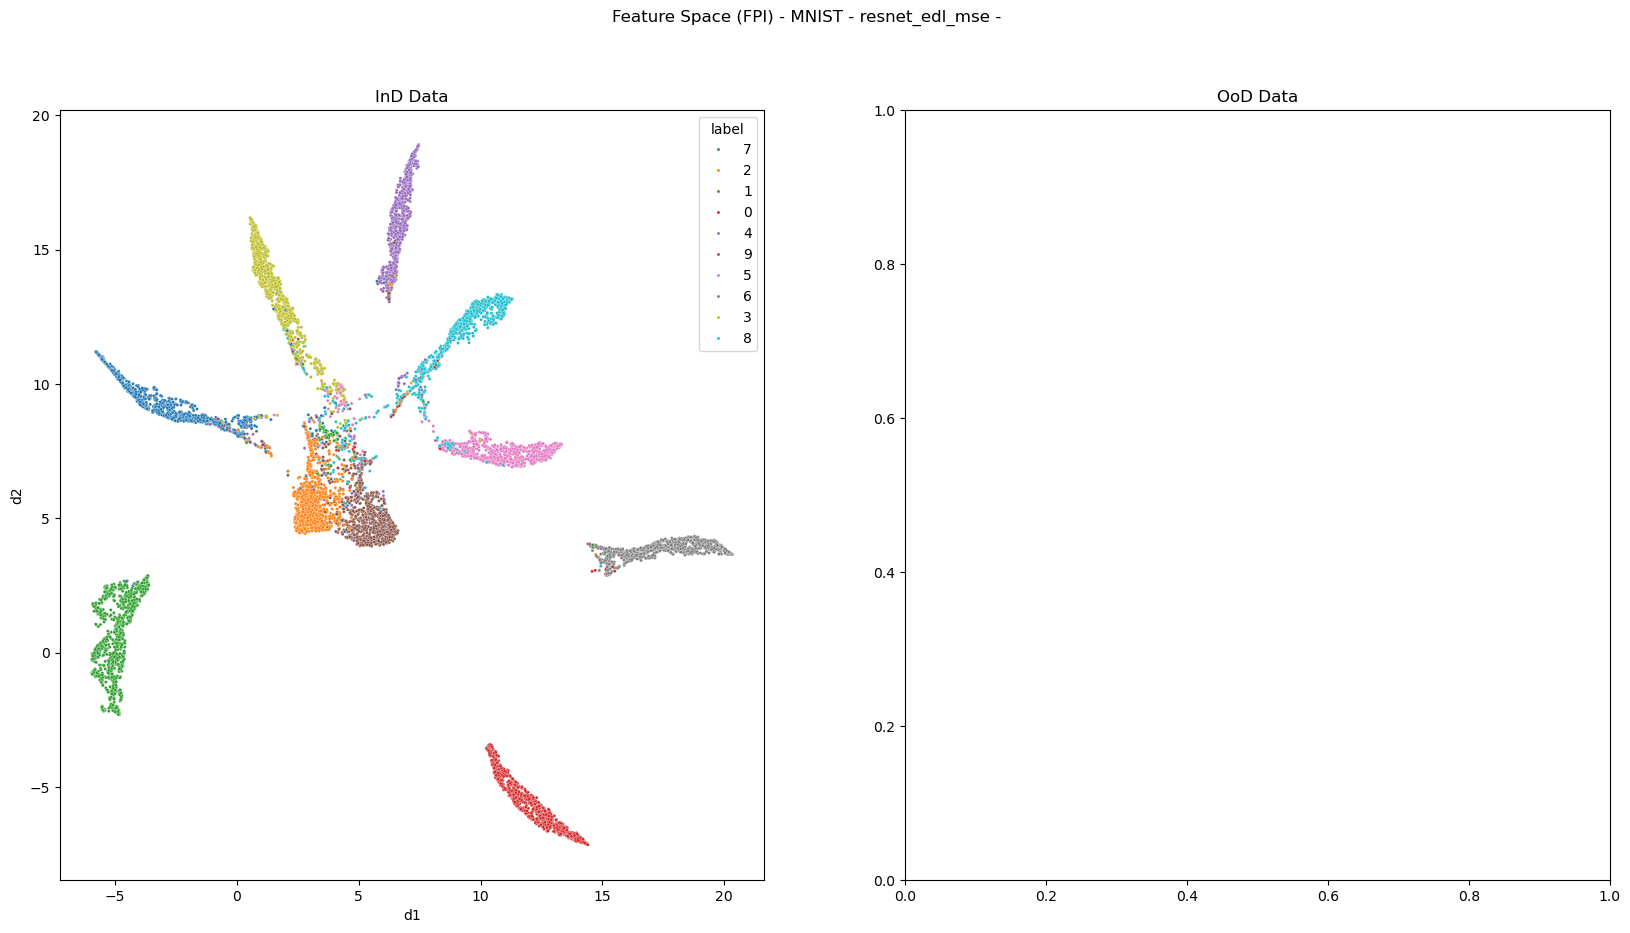

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

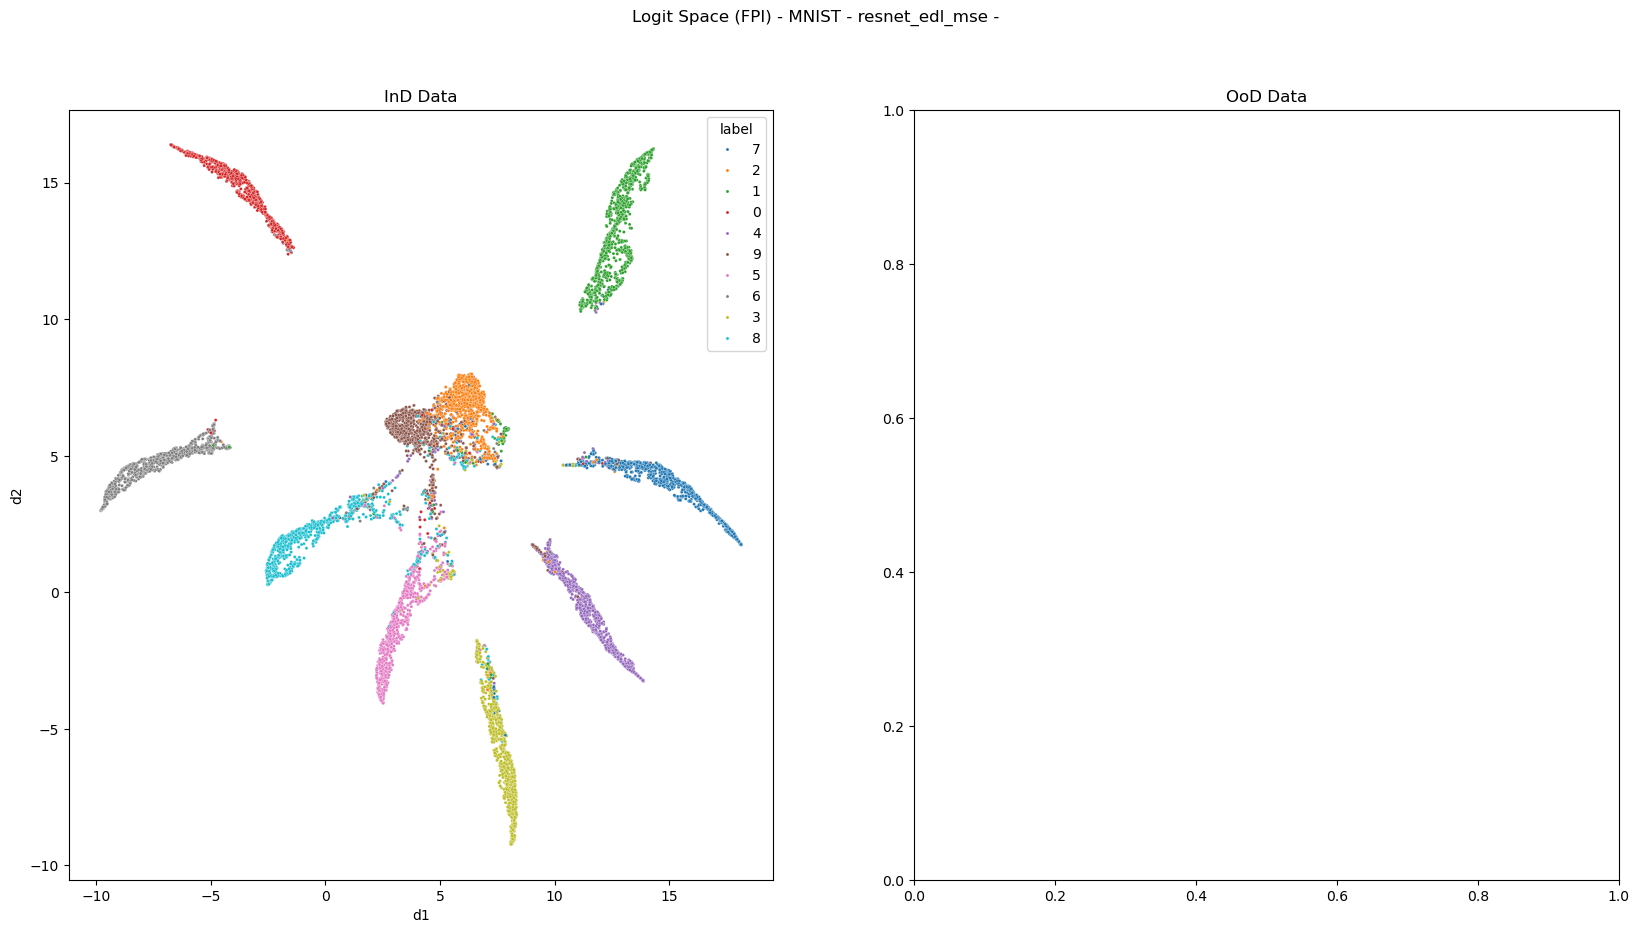

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

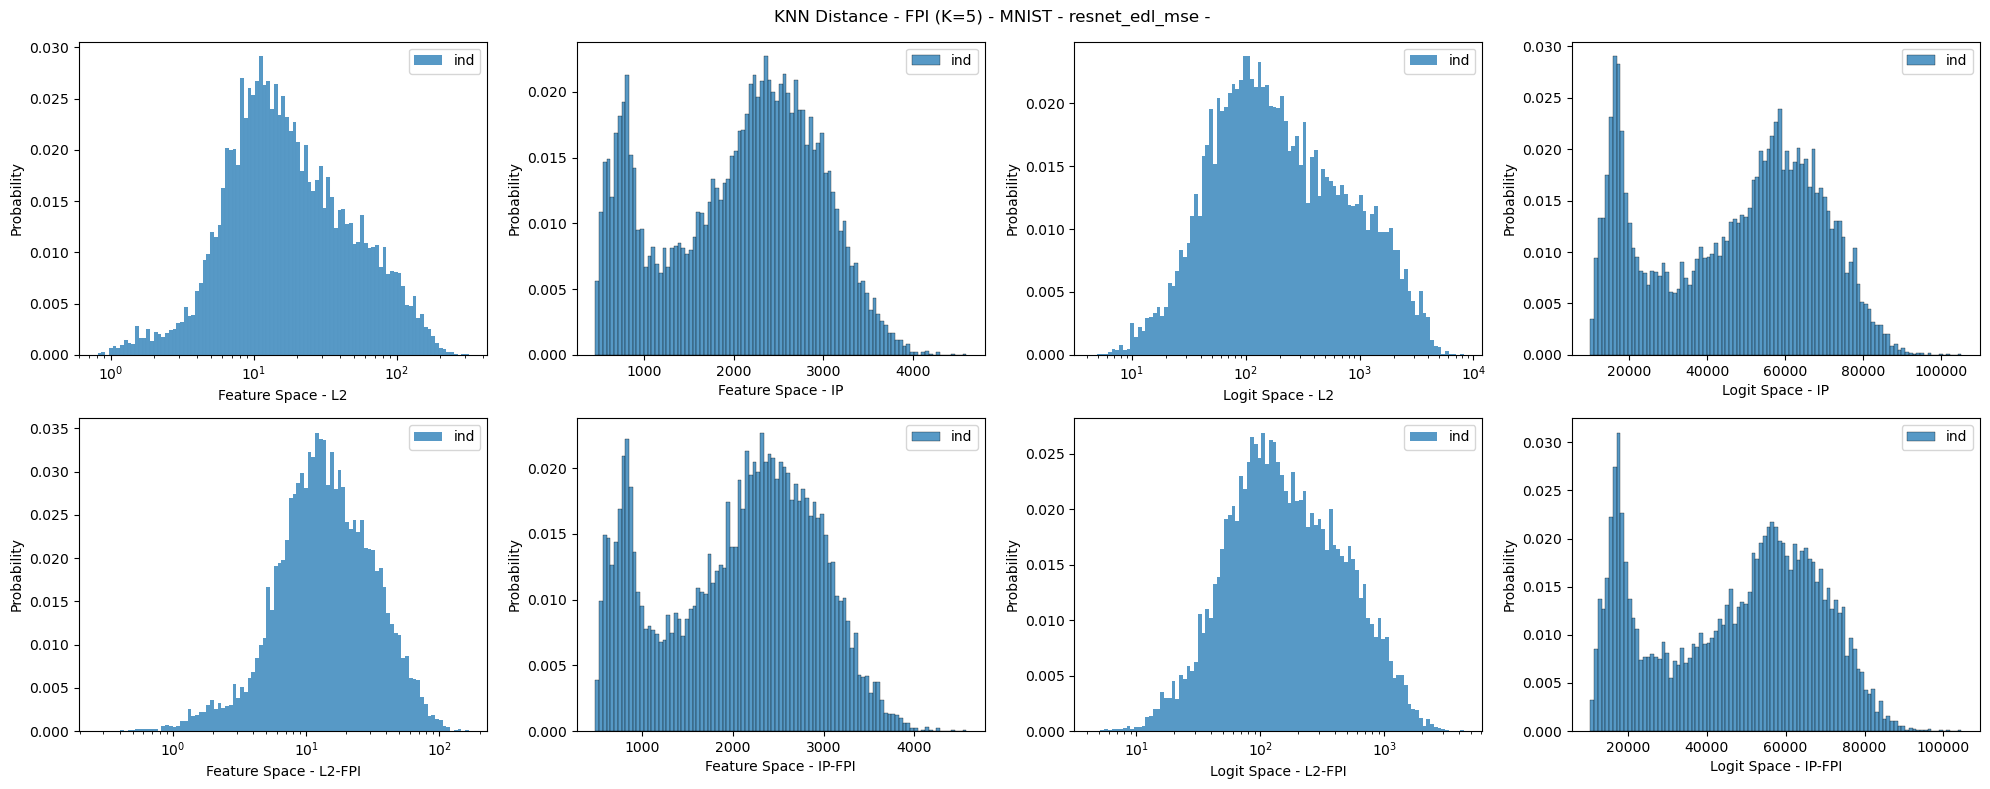

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
run_stats["knn_f_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
run_stats["knn_f_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
run_stats["knn_l_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
run_stats["knn_l_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

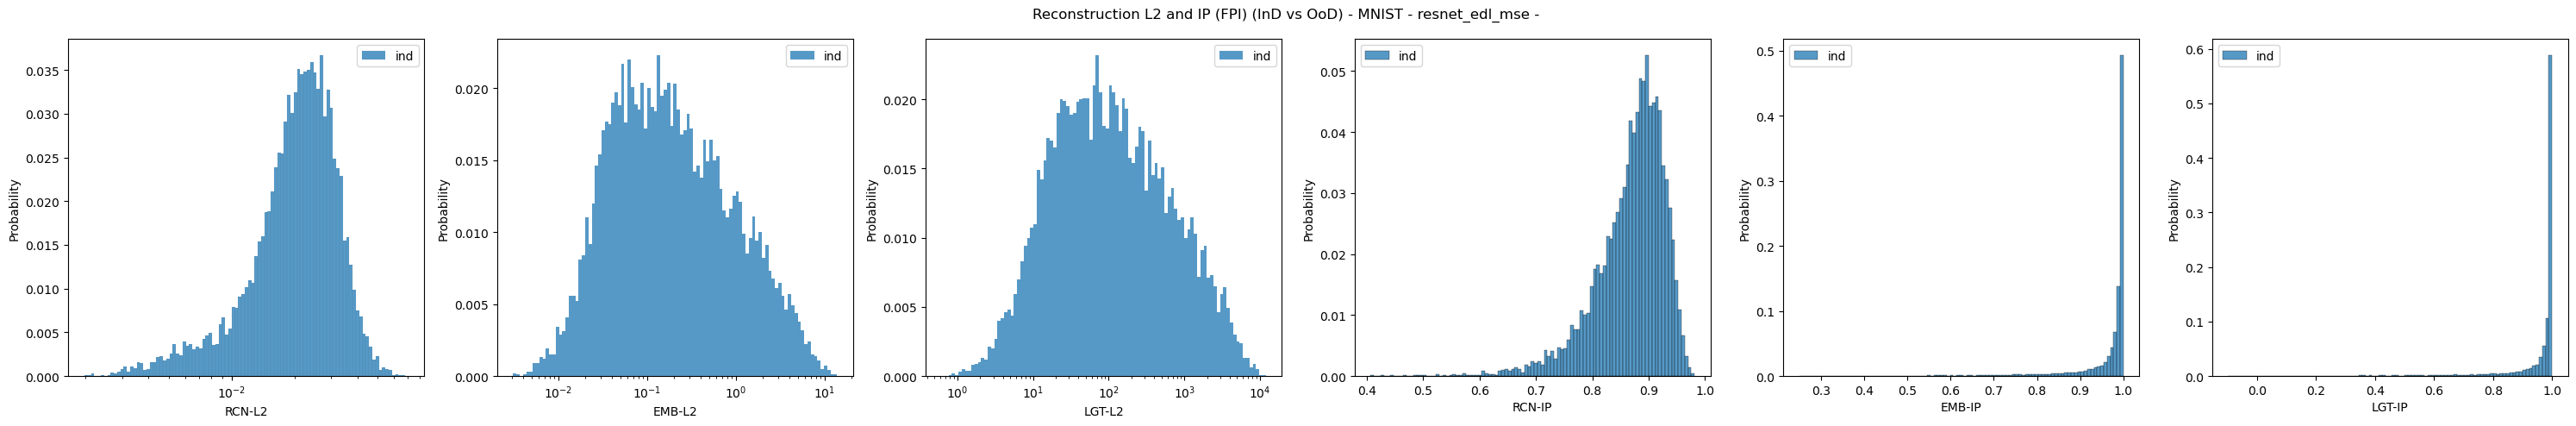

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["emb_l2"] = plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["lgt_l2"] = plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["emb_ip"] = plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["lgt_ip"] = plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

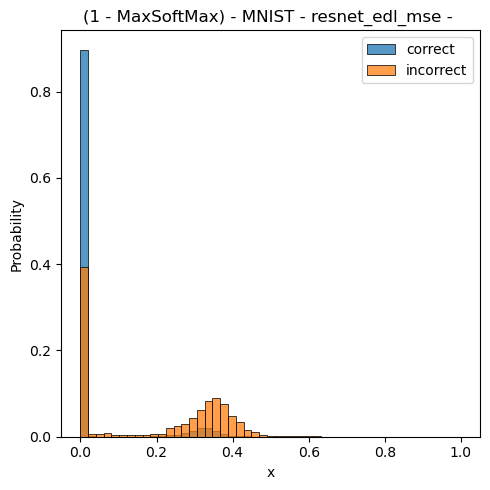

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

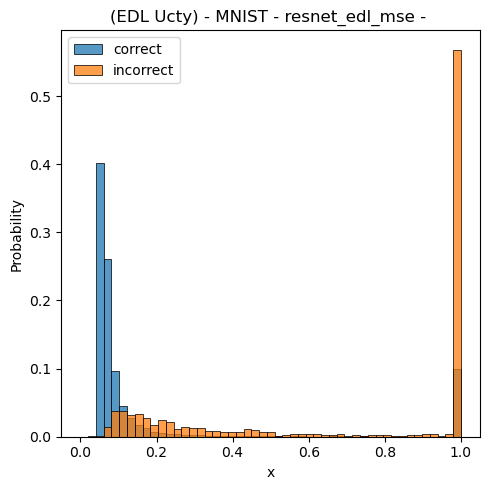

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [19]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)